# はじめに
静的な場合の有限要素法問題における変位は以下のような連立方程式をとくことにより得られます。

$KU=F$ 

$HU=R$

ここで、$K$は剛性行列、$U$は変位ベクトルです。
一方、$F$は外力ベクトル(NEUMANN条件)であり、$HU=R$は固定端やローラー条件(DIRICHLET条件)です。

この資料は三脚のメッシュをpythonでインポートし、境界条件を設定し剛性行列$K$と外力ベクトル$F$を作成して変位$U$を計算する過程を説明したものです。

# インストールとモジュールのインポート

## インストール方法

### Linux(Ubuntu)

まずはGetfem++のpythonインターフェースのモジュールをインポートします。Ubuntu系のOSではインストールコマンドは

`$ sudo apt-get update; sudo apt-get install python-getfem++`

です。さらに、境界条件設定に使うためnumpyをインポートします。numpyはpython-getfem++と依存関係にあるため、自動的にインストールされます。インストールが終わったら、結果出力とGUI表示のため、gmshとipython-notebookをインストールしましょう。

`$ sudo apt-get install gmsh pip; sudo pip install ipython-notebook`

このファイルがあるディレクトリに移動

`$ ipython notebook`

で、Ipython Notebookを起動した後このファイルを開いてください。

### Windows

Python 2.7系の32bit版をインストール(Getfem++のWindows版が32bit版しかないので、32bit版でないと動かない)

https://www.python.org/ftp/python/2.7.10/python-2.7.10.msi

以下のファイルで、Python2.7系のGetfem++モジュールをインストールします。

http://download.gna.org/getfem/misc/getfem_python-4.1.win32-py2.7.exe

あとは、パスを通したpipコマンドで、numpyとipythonをインストールします。

管理者権限のコマンドライン

> pip install notebook

> pip install numpy

numpyのインストールはCコンパイラが必要になるので、メッセージをよく読みインストールをしてください。

## モジュールのインポート

慣例的にGetfem++はgfとしてインポートし、numpyはnpとしてインポートします。

In [1]:
import getfem as gf
import numpy as np

# パラメータの設定
まずはパラメータを設定します。この例では、このファイルからの相対パスが './mesh/tripod.mesh'であるメッシュファイルを使用します。メッシュは四面体要素です。ヤング係数$E = 1.0\times10^3$、ポアソン比$\nu = 0.3$とします。

In [2]:
file_msh = './mesh/tripod.mesh'
E = 1e3
Nu = 0.3
Lambda = E*Nu/((1+Nu)*(1-2*Nu))
Mu = E/(2*(1+Nu))

# メッシュの読み込み
メッシュを外部ファイルから読み込みます。メッシュの入力データはGetfem++の独自のフォーマットになっていますが、解読は容易だと思います。

In [3]:
m = gf.Mesh('load',file_msh)
m.set('optimize_structure')

次のコマンドで、mに設定したメッシュをgmshのスクリプトでpng画像に打ち出し確認します。

In [4]:
m.export_to_pos('./pos/m.pos')

以下のようにipythonの機能を使用して、システムのコマンドラインでの操作を行いIpython上に画像を表示してみます。もちろん、gmshで直接posファイルを表示することもできます。

In [5]:
%%writefile gscript
Print "./png/m.png";
Exit;

Writing gscript


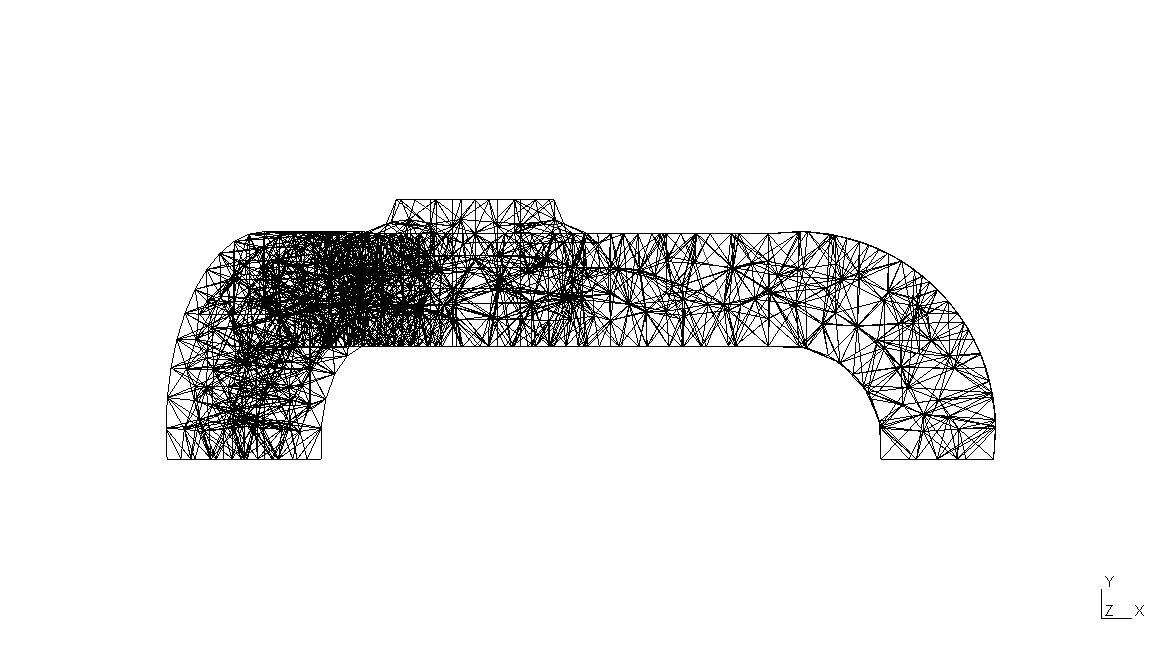

In [6]:
!gmsh ./pos/m.pos gscript
from IPython.core.display import Image
Image('./png/m.png')

これは横から見たメッシュ図です。三脚のメッシュであることがわかります。今回はこの頂点部分に荷重(NEUMANN条件)、下端に固定条件(DIRICHLET条件)を与え変位を計算することにします。

# FEMと立体求積法の設定
変数mにセットされたメッシュからそれぞれ変位応答格納用の変数と各節点データ操作用の変数を作成しておきます。GetFEM++の特徴として積分法の選択肢の多さがあります。

In [7]:
mfu = gf.MeshFem(m,3) # displacement
mfd = gf.MeshFem(m,1) # data

mfuとmfdにはそれぞれLagrange要素$Q_3$と$Q_1$が入ります。$Q_3$は変位用、$Q_1$はMises応力などのデータ用に準備したものです。
FEM手法として古典的なLagrange要素$P_k$を割り当てます。

| degree               | dimension            | d.o.f. number                        | class        | vectorial                | $\tau$-equivalent        | Polynomial   |
|:--------------------:|:--------------------:|:------------------------------------:|:------------:|:------------------------:|:------------------------:|:------------:|
| $K,0\leq K\leq255$   | $P,1\leq K\leq255$   | $\dfrac{\left(K+P\right)!}{K!P!}$    | $C^0$        | No$\left(Q=1\right)$     | Yes$\left(M=Id\right)$   | Yes          |


In [8]:
mfu.set_fem(gf.Fem('FEM_PK(3,1)'))
mfd.set_fem(gf.Fem('FEM_PK(3,0)'))

立体求積法には15積分点・5次のtetrahedronを使用します。

<img src="./image/getfemlistintmethodtetrahedron5.png">


In [9]:
mim = gf.MeshIm(m,gf.Integ('IM_TETRAHEDRON(5)'))

# 領域の定義
次に領域を定義し、境界条件を設定する布石とします。今回は三脚の上端にNEUMANN条件を、下端にDIRICHLET条件を設定します。
大き流れとしては以下の通りです。

* 節点の座標を取得
* 節点が領域に属しているかの真偽表の配列を作成
* 領域に属している節点のみ節点番号を抜き出す
* 節点番号から要素の面の情報を抜き出す
* 要素番号と面番号の情報を元に領域に番号をつける

## 節点の座標を取得

メッシュmの節点の座標を出力するためには、m.pts()を使用します。この関数により行方向がXYZ軸、列方向が各節点を意味している座標の配列が得られます。

In [10]:
P = m.pts()
print P

[[-27.3301  -26.7189  -26.2128  ...,  44.4658   45.4549   46.     ]
 [-10.      -10.       -9.99999 ...,  -8.66561  -2.3968   -9.99999]
 [ 37.3372   36.2784   37.9822  ...,  -3.78234  -1.28734  -1.27397]]


Gmshで先ほど出力したメッシュを確認してみるとY座標が最大になっている部分に三脚の上端が、Y座標が最小になっている部分に三脚の下端があることがわかります。それぞれの座標をPで確認しておきましょう。

In [11]:
print 'Ymax = ', P[1,:].max()
print 'Ymin = ', P[1,:].min()

Ymax =  13.0
Ymin =  -10.0


## 節点が領域に属しているかの真偽表の配列を作成
Y座標上の最大値と最小値がわかりましたので、その部分に節点が属しているかの真偽表の配列を作ります。頂部(ctop)は最大値$13$との差が$10^{-6}$の場合に節点が領域に含まれているとみなし、下端は最小値$-10$との差が$10^{-6}$の場合に領域に属しているとみなします。

In [12]:
ctop = (abs(P[1,:] - 13) < 1e-6)
print 'ctop = ', ctop
cbot = (abs(P[1,:] + 10) < 1e-6)
print 'cbot = ', cbot

ctop =  [False False False ..., False False False]
cbot =  [ True  True False ..., False False False]


## 領域に属している節点のみ節点番号を抜き出す
次に領域に属している節点のみ節点番号を抜き出します。意図した操作はNumpyのcompress関数とPythonのrange関数で可能です。ちなみに、m.nbptsはメッシュmの節点数(Number of Points)を意味しています。

In [13]:
pidtop = np.compress(ctop,range(0,m.nbpts()))
pidbot = np.compress(cbot,range(0,m.nbpts()))
print 'pidtop = ', pidtop
print 'pidbot = ', pidbot

pidtop =  [1796 1798 1816 1826 1849 1865 1911 1924 1925 1932 1946 1952 1981 1986 1989
 1998 2044 2046 2049 2050 2059 2065 2076 2088 2109 2120 2121 2131 2146 2167
 2171 2178 2203 2204 2249 2250 2265 2273 2293 2306 2331 2352 2359 2382 2401
 2407 2435 2453 2471 2497 2511 2526 2534 2551 2588 2621 2625 2628 2629 2642
 2705 2711 2719 2728 2736 2743 2761 2768 2782 2787 2806 2815 2817 2851 2894
 2899 2934 2944 2949 2951 2970 2977 3018 3037 3085 3100 3143 3154 3175 3180]
pidbot =  [   0    1    5    8   11   14   18   24   25   27   31   40   41   42   46
   52   56   67   70   72   73   77   80   85   97  107  114  115  116  117
  127  131  132  136  145  165  166  170  171  174  182  184  193  194  196
  198  218  221  223  224  247  250  272  275  277  311  312  344 1313 2969
 4144 4206 4232 4269 4306 4332 4337 4395 4403 4411 4429 4433 4469 4491 4539
 4543 4546 4581 4622 4625 4626 4660 4662 4686 4689 4696 4705 4706 4743 4747
 4751 4763 4777 4801 4808 4815 4836 4838 4845 4849 4852 4857 4861 4

# 節点番号から要素の面の情報を抜き出す
次に節点番号から要素の面を格納した配列を作成します。この操作はメッシュmに対してm.faces_from_pid()の関数で操作可能です。この配列には１行目に要素番号、２行目に要素内での面番号を格納しています。

In [14]:
ftop = m.faces_from_pid(pidtop)
fbot = m.faces_from_pid(pidbot)
print 'ftop = ', ftop
print 'fbot = ', fbot

ftop =  [[666 670  68 127  70 132 134 693 128 685 691 687 125 133  71 130  66 126
  662 123 665 669 129 663  67 131  69 124 689 694]
 [  2   2   3   3   3   3   3   2   3   2   2   2   3   3   3   3   3   3
    2   3   2   2   3   2   3   3   3   3   2   2]]
fbot =  [[ 502  999 1082  327 1827 1013 1892  908 1024  468  410  971  324  804
   847  434  433  712  896  326 1067 1822 1918  984 1063  472  469  858
   470  909 1025 1029  323  986  328  717 1867 1893  435  848  998 1083
   503  418  325  970 1012  409]
 [   3    2    0    3    3    2    2    2    2    2    2    1    3    3
     2    2    2    3    2    3    2    3    2    2    1    2    2    2
     2    2    2    2    3    0    3    3    2    2    2    2    2    0
     2    2    3    1    2    2]]


## 要素番号と面番号の情報を元に領域に番号をつける
最後に、面の情報を元にメッシュmに境界領域を作成し付番します。使用する関数はm.set_regionです。

In [15]:
NEUMANN_BOUNDARY = 1
DIRICHLET_BOUNDARY = 2
m.set_region(NEUMANN_BOUNDARY,ftop)
m.set_region(DIRICHLET_BOUNDARY,fbot)

# 外力ベクトルと剛性マトリックスの組み立て
以上で設定した条件を使用して外力ベクトルと剛性行列を設定します。

In [16]:
nbd = mfd.nbdof()
F = gf.asm_boundary_source(NEUMANN_BOUNDARY, mim, mfu, mfd, np.repeat([[0],[-100],[0]],nbd,1))
K = gf.asm_linear_elasticity(mim, mfu, mfd, np.repeat([Lambda], nbd), np.repeat([Mu], nbd))
sl = gf.Slice(('boundary',), mfu, 1)
sl.export_to_pos('./pos/F.pos',mfu,F,'F')

In [17]:
%%writefile gscript
Print "./png/F.png";
Exit;

Overwriting gscript


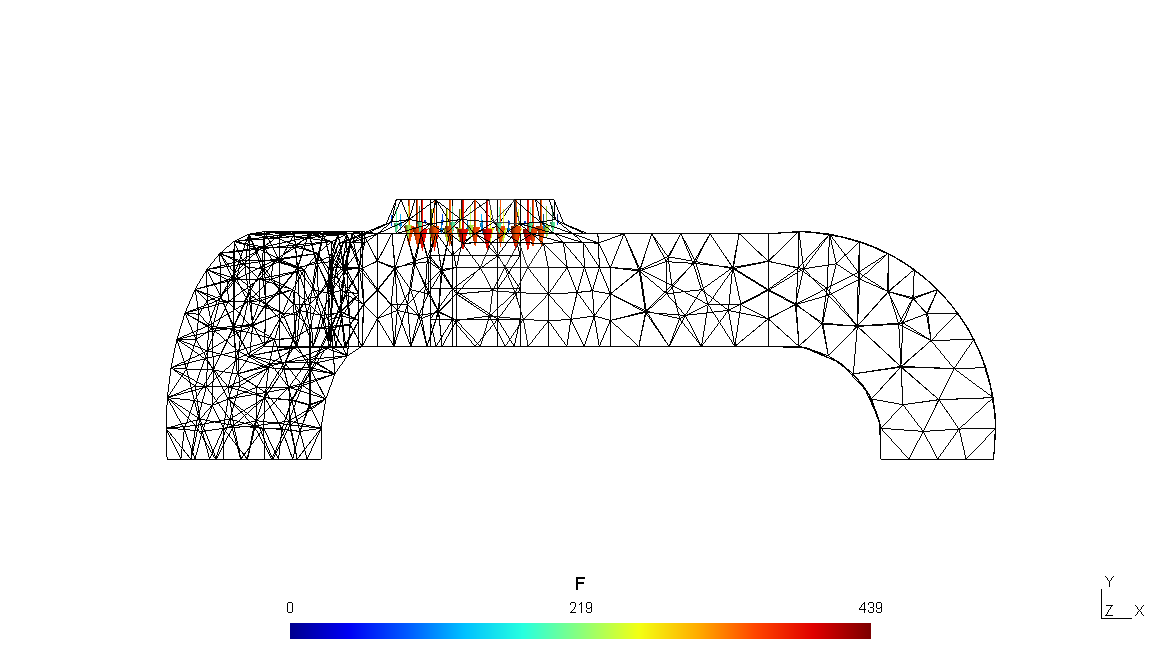

In [18]:
!gmsh ./pos/F.pos gscript
from IPython.core.display import Image
Image('./png/F.png')

# 固定条件の設定
DIRICHLET条件(固定端条件)の設定をします。DIRICHLET条件は以下のような式で表される境界条件です。

$HU = R$

固定条件を与える場合は対象領域の節点に

$\left[\begin{array}{ccc}
1\\
 & 1\\
 &  & 1
\end{array}\right]\left\{ \begin{array}{c}
U_{x}\\
U_{y}\\
U_{z}
\end{array}\right\} =\left\{ \begin{array}{c}
0\\
0\\
0
\end{array}\right\} $

の関係を与える必要があります。すなわち、対象領域のみに

$H=\left[\begin{array}{ccc}
1\\
 & 1\\
 &  & 1
\end{array}\right]$、$R=\left\{ \begin{array}{c}
0\\
0\\
0
\end{array}\right\} $

になる行列を与えてれる関数が必要です。それが以下のgf.asm_dirichlet関数です。


In [19]:
(H,R) = gf.asm_dirichlet(DIRICHLET_BOUNDARY, mim, mfu, mfd, mfd.eval('[[1,0,0],[0,1,0],[0,0,1]]'), mfd.eval('[0,0,0]'))

さて、Getfem++では、はじめにご説明した連立方程式の問題を以下のように言い換えます。

$KU = F$ ただし、$HU = R$

$\Downarrow$

$(N^TKN)U^* = N^TF$ ただし、$U = NU^* + U_0$

この$N$は例えば条件が固定端の場合にはその自由度の行と列を削除する効果があります。この$N$と$U_0$は次の関数で計算できます。

In [20]:
(N,U0) = H.dirichlet_nullspace(R)
Nt = gf.Spmat('copy',N)
Nt.transpose()
KK = Nt*K*N
FF = Nt*(F-K*U0)

# 変位の計算
以上で計算するべき連立方程式の剛性行列と外力ベクトルが定まりましたので、連立方程式を解きます。Getfem++のモジュールで剛性行列からプリコンディショナーを用意し、CG法を利用して変位を計算します。

In [21]:
P = gf.Precond('ildlt',KK)
UU = gf.linsolve_cg(KK,FF,P)
U = N*UU+U0

# ポスト処理
以上で計算した変位をポスト処理結果として出力します。まずスライスモジュールを使用して、メッシュの外側の部分のみ抜き出します。次にスライスオブジェクトに変位の計算結果と凡例を渡して、posファイルに出力します。これで、'Displacement'と凡例のあるposファイルが'./pos/m_result.pos'というファイルに出力されたことになります。

In [22]:
sl = gf.Slice(('boundary',), mfu, 1)
sl.export_to_pos('./pos/m_result.pos', mfu, U, 'Displacement')

In [23]:
%%writefile gscript
Print "./png/m_result.png";
Exit;

Overwriting gscript


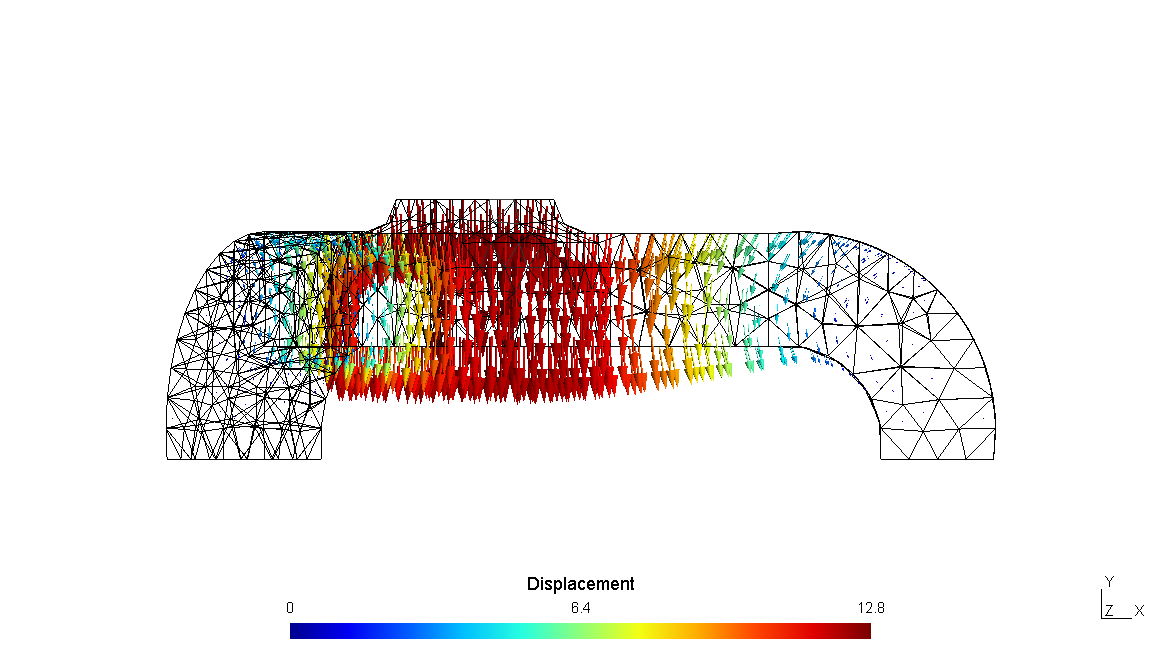

In [24]:
!gmsh ./pos/m_result.pos gscript
from IPython.core.display import Image
Image('./png/m_result.png')

# 結果の可視化

以上の様にそれぞれの方向から見た変位の計算結果をコンターで可視化することが可能です。sl.export_to_posという別の関数を使えばParaviewでvtkファイルによる可視化も可能です。（ただし、VTKファイル出力はWindows上ではうまくいきません。テキストファイル出力のgmshが安定しています。）

# まとめ

以上、メッシュの読み込みから要素と積分点の設定、領域と境界条件の定義から変位の計算のポスト出力までを行いました。もともと、Pythonは行列の操作がとても簡単であるため、Getfem++のモジュールを使用することにより有限要素法の実施が可能です。

今後の話題として以下のようなものを用意しています。

* Pythonによる有限要素法の固有値解析(構造)

* Pythonによる時刻歴応答解析(構造)